Case Study
---
Do you want to buy a new laptop? If yes, what is your concern?, Price, or its equipment?

Before making the decision, let us explore the price of laptop.

To make the accurate information, 
1. we will make a detailed Exploratory Data Analysis (EDA), or called data washing; 
2. create a model for prediction of the value of laptop; 
3. Deployment of the Model.


Skills of Pandas manipulation
---
1. `df['Memory].unique()`, set of terms in this feature; 特徵項目
2. `df['Memory].value_counts()`, count of each unique term in this feature; 特徵項目數量
3. `df["Memory"].str.split(pat=pattern,expand=True)`, split string into different features, by using `pattern` as the delimiter string. 依照特徵分解特徵值
4.  `df['Price'].apply(lambda x:np.log1p(x))`, evaluate the feature by `log(1+x)`, i.e. the quantity of exponential term since it might be in too large scale, 取對數，log(1+x), 因為數量級太大所以取指數的量 
5.  Extract the part of digits, where  
```
# more than one digit, 包含至少一個數字
pattern='(\d+)'
df['Memory'].str.extract(pattern,expand=True)
```
5. Extract the part of letters, 包含至少一個英文字母
```
# more than one letter, capital or not
pattern='([A-Za-z+]+)'
df['Memory'].str.extract(pattern,expand=True)
```

In [ ]:
# update the package to make the visualisation work in colab
# 如果不肯定 Google drive 是否能夠印出來，可以先行在執行程式之前，更新 matplotlib 

!pip install -U matplotlib seaborn

In [1]:
import pandas as pd 
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
# pkg for interactive vis

import warnings
warnings.filterwarnings('ignore')
#把warning省略掉

%matplotlib inline

Using lux
---
Lux helps pandas DataFrame to visualize output automatically and efficiently. Lux 用視覺化的方式，幫忙找出數據之間的關係

```
[installation and Usage]
# installation 安裝方式
!pip install lux-api

# use on Google drive, 在 Google Drive 上面使用
from google.colab import output
output.enable_custom_widget_manager()


import lux
df = ...
df
# click [Toggle Pandas/Lux] to work, 啟動

# or use by chosen target, "Price",依照某個參數觀察
df.intent = ["Price"]
df
```

In [2]:
# Data, 資料來源
file="https://raw.githubusercontent.com/Raghavagr/Laptop_Price_Prediction/main/laptop_data.csv"
#file="Laptop_prive.csv"

df = pd.read_csv(file) 

In [ ]:
# save the data without index, 如果要存檔

df.to_csv("Laptop_prive.csv",index=0)

In [ ]:
df.head()

Value of Laptop, 手提電腦的價值
---
Value of laptop is certainly included the following equipments, 手提電腦的價值包含下列設備:
```
Company
TypeName
Inches
ScreenResolution
CPU
GPU
Memory
OP sys
Ram
```
To predict the value, we have to get out the "RIGHT" information of data by EDA. 利用 EDA 取出正確的資料來估計價值

Exploratory Data Analysis, EDA
---

### 1. Ram, Weight

In [4]:
# delete the useless feature, 消除沒用的欄位，

df.drop(columns=['Unnamed: 0'],inplace=True)

## remove gb and kg from Ram and weight and convert the cols to numeric, 除掉去除單位，留下數目字

df['Ram'] = df['Ram'].str.replace("GB", "")
df['Weight'] = df['Weight'].str.replace("kg", "")
df['Ram'] = df['Ram'].astype('int32')
df['Weight'] = df['Weight'].astype('float32')

# Transform unit of price and make it in hundreds, 轉換價值單位，並最小為 00 計價  
df['Price'] = ((0.39*df['Price']//100)*100).astype('int')

# Prediction


[Regression Prediction, pycaret](#Prediction-by-Pycaret)
1. first case:
```
features=['Ram','Weight']
target='Price']
```

In [3]:
def feature_vis(df,col):
    plt.figure(figsize=(12,8))

    sns.set_style('darkgrid')
    sns.countplot(data=df,x=col)
    plt.xticks(rotation="vertical");
    plt.show()

### 2. CPU and GPU
---
Only companies and running velocity to be extracted, 使用哪一家的中央處理器，和執行速度
1. companies: Intel ( `core i*` or `not`) , AMD, others
2. velocity: `%d.%d`GHz

#### Steps
---
1. Classify what kind of CPU, 中央處理器的品牌: 
    - Intel:  a) `core-i` series or b) `not Intel core-i`, 
    - `AMD`
    - and `others`

```
# split by space, get the first 3 words, e.g. Intel Core i7, 取出前面三個資料

" ".join(x.split()[0:3])
```
2. velocity of CPU, extract the string `*.*` from `*.*GHz` and convert it to float, 取出執行速度，去掉單位並轉為小數:
```
# define the pattern, at least one digit after . and before GHz
pattern='([.\d]+GHz)'
df['CPU_vel']=(df['Cpu'].str.extract(pattern,expand=True))
# convert to float
df['CPU_vel']=df['Cpu'].apply(lambda x: str(x)[:-3]).astype(float)
```

3. Company of GPU, Intel, Nvidia, AMD or other, 圖形處理器的品牌:
```
pattern=' '
df['GPU']=df['Gpu'].str.split(pat=pattern,expand=True)[0]
```

In [11]:
# CPU data, 有哪些型態的中央處理器，下列則找出處理器的執行速度

np.sort(df['Cpu'].unique())

array(['AMD A10-Series 9600P 2.4GHz', 'AMD A10-Series 9620P 2.5GHz',
       'AMD A10-Series A10-9620P 2.5GHz', 'AMD A12-Series 9700P 2.5GHz',
       'AMD A12-Series 9720P 2.7GHz', 'AMD A12-Series 9720P 3.6GHz',
       'AMD A4-Series 7210 2.2GHz', 'AMD A6-Series 7310 2GHz',
       'AMD A6-Series 9220 2.5GHz', 'AMD A6-Series 9220 2.9GHz',
       'AMD A6-Series A6-9220 2.5GHz', 'AMD A8-Series 7410 2.2GHz',
       'AMD A9-Series 9410 2.9GHz', 'AMD A9-Series 9420 2.9GHz',
       'AMD A9-Series 9420 3GHz', 'AMD A9-Series A9-9420 3GHz',
       'AMD E-Series 6110 1.5GHz', 'AMD E-Series 7110 1.8GHz',
       'AMD E-Series 9000 2.2GHz', 'AMD E-Series 9000e 1.5GHz',
       'AMD E-Series E2-6110 1.5GHz', 'AMD E-Series E2-9000 2.2GHz',
       'AMD E-Series E2-9000e 1.5GHz', 'AMD FX 8800P 2.1GHz',
       'AMD FX 9830P 3GHz', 'AMD Ryzen 1600 3.2GHz',
       'AMD Ryzen 1700 3GHz', 'Intel Atom X5-Z8350 1.44GHz',
       'Intel Atom Z8350 1.92GHz', 'Intel Atom x5-Z8300 1.44GHz',
       'Intel Atom x5-Z835

In [ ]:
# Run velocity of CPU, 中央處理器的執行速度
# x.
pattern='(\d.\dGHz)'
df['Cpu'].str.extract(pattern,expand=True)

In [12]:
np.sort(df['Gpu'].unique())

array(['AMD FirePro W4190M', 'AMD FirePro W4190M ', 'AMD FirePro W5130M',
       'AMD FirePro W6150M', 'AMD R17M-M1-70', 'AMD R4 Graphics',
       'AMD Radeon 520', 'AMD Radeon 530', 'AMD Radeon 540',
       'AMD Radeon Pro 455', 'AMD Radeon Pro 555', 'AMD Radeon Pro 560',
       'AMD Radeon R2', 'AMD Radeon R2 Graphics', 'AMD Radeon R3',
       'AMD Radeon R4', 'AMD Radeon R4 Graphics', 'AMD Radeon R5',
       'AMD Radeon R5 430', 'AMD Radeon R5 520', 'AMD Radeon R5 M315',
       'AMD Radeon R5 M330', 'AMD Radeon R5 M420', 'AMD Radeon R5 M420X',
       'AMD Radeon R5 M430', 'AMD Radeon R7', 'AMD Radeon R7 Graphics',
       'AMD Radeon R7 M360', 'AMD Radeon R7 M365X', 'AMD Radeon R7 M440',
       'AMD Radeon R7 M445', 'AMD Radeon R7 M460', 'AMD Radeon R7 M465',
       'AMD Radeon R9 M385', 'AMD Radeon RX 540', 'AMD Radeon RX 550',
       'AMD Radeon RX 560', 'AMD Radeon RX 580', 'ARM Mali T860 MP4',
       'Intel Graphics 620', 'Intel HD Graphics', 'Intel HD Graphics 400',
       'Inte

### CPU

[Cpu] ➜ ['CPU_vel', 'Cpu_brand']

新增兩個特徵, ['CPU_vel', 'Cpu_brand']

In [5]:
#first we will extract Name of CPU which is first 3 words from Cpu column and then we will check which processor it is
def fetch_processor(x):
  cpu_name = " ".join(x.split()[0:3])
  if cpu_name == 'Intel Core i7' or cpu_name == 'Intel Core i5' or cpu_name == 'Intel Core i3':
    return cpu_name
  elif cpu_name.split()[0] == 'Intel':
    return 'Other Intel Processor'
  elif cpu_name.split()[0] == 'AMD':
    return cpu_name    
  else:
    return 'Others Processor'

def EDA_CPU(df_,f_='Cpu'):
    # has one digit or none before GHz, GHz 之前有一個或沒有小數點
    pattern='([.\d]+GHz)'
    df_['CPU_vel']=(df_[f_].str.extract(pattern,expand=True))
    # keep the info before GHz, 保留 GHz 之前的資料
    df_['CPU_vel']=df_['CPU_vel'].apply(lambda x: str(x)[:-3]).astype(float)
    return df_

df['Cpu_brand'] = df['Cpu'].apply(lambda x: fetch_processor(x))
df=EDA_CPU(df)


In [14]:
df[['Cpu','Cpu_brand','CPU_vel']].head()

,Cpu,Cpu_brand,CPU_vel
0,Intel Core i5 2.3GHz,Intel Core i5,2.3
1,Intel Core i5 1.8GHz,Intel Core i5,1.8
2,Intel Core i5 7200U 2.5GHz,Intel Core i5,2.5
3,Intel Core i7 2.7GHz,Intel Core i7,2.7
4,Intel Core i5 3.1GHz,Intel Core i5,3.1


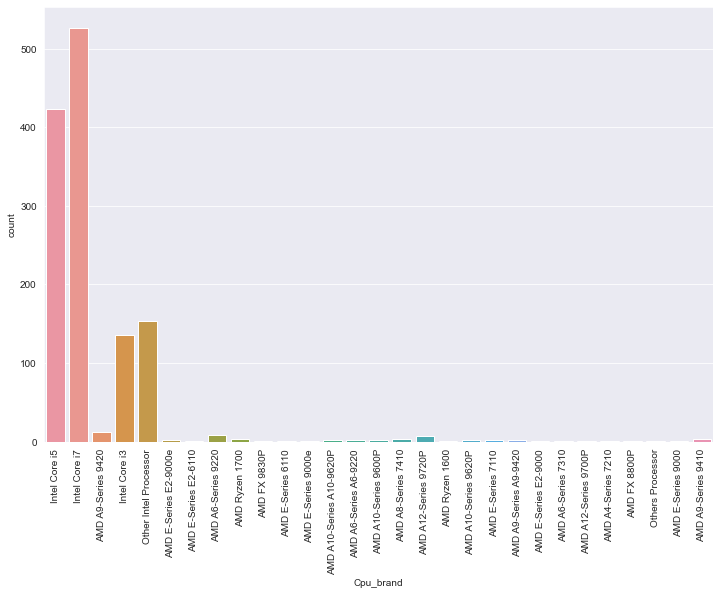

In [15]:
feature_vis(df,'Cpu_brand')

Note
---
Most of devices are equipped with `Intel`-cloned CPU; this could be ignored the others. 

#### GPU

extract kind of GPU, ['GPU']

找出圖形處理器的品牌，新增 ['GPU']

In [6]:
def EDA_GPU(df_,f_='Gpu'):
    pattern=' '
    df_['GPU']=df_[f_].str.split(pat=pattern,expand=True)[0]
    return df_

df=EDA_GPU(df)

In [ ]:
df[['Cpu','Cpu_brand','CPU_vel','Gpu','GPU']].head()

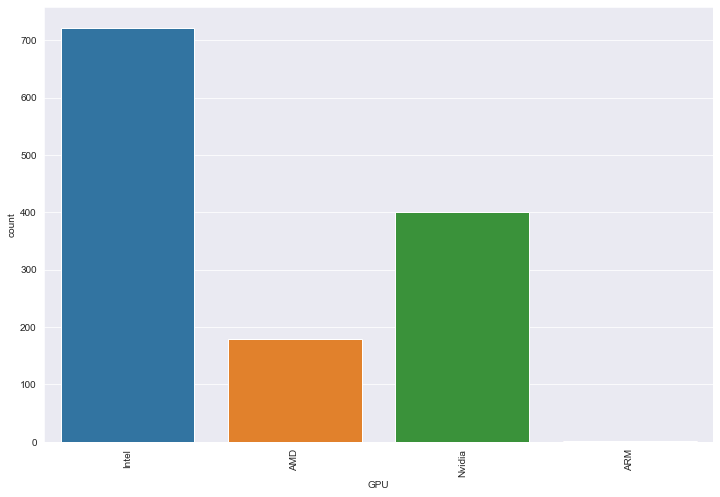

In [19]:
feature_vis(df,'GPU')

2. Second case:
```
features=['Ram','Weight','Cpu','Cpu_brand','CPU_vel','Gpu','GPU']
target='Price']
```

<Figure size 864x576 with 0 Axes>

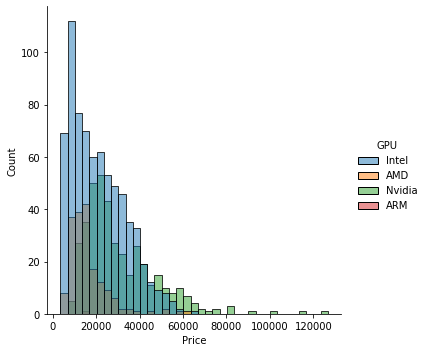

In [13]:
plt.figure(figsize=[12,8])
sns.displot(data=df,x='Price',hue='GPU')
#sns.displot(data=penguins, x="flipper_length_mm", hue="species", multiple="stack")



<Figure size 864x576 with 0 Axes>

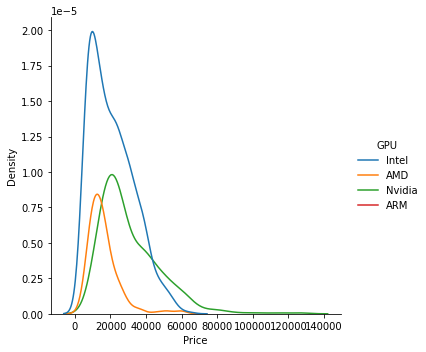

In [14]:
plt.figure(figsize=[12,8])
sns.displot(data=df,x="Price",kind="kde",hue="GPU")


### 3. EDA of Memory
---
This feature contains the specification of storage, which is highly related the selling price of device. The format
of feature includes the following, 硬碟配備數目和容量大小:

1. `digit(s) letters`, 硬碟容量大小 硬碟種類: 
```
digits: size of memory, null, 2, 8, 16 ...,
letters: type of storages, SSD, Flash Storage, HDD, Hybrid
```
2.` * + *`: more than two kinds of storages equipment, 兩個硬碟使用 "+" 隔開:
```
256(512) SSD + 256 SSD, 256 SSD + HDD, 64 Flash Storage + HDD, 256(512) SSD + Hybrid, HDD + HDD
```

And the important factors are:
1. kind of storage, `HDD, SSD, Flash Storage`, 硬碟種類，其他;
2. number of storages: 1, or 2 (hybrid, or cell, containing `+`)，一個或兩個硬碟
3. size of each storage:, 1, 2, 16, 64, 256, 512，硬碟容量;
4. others (?)，其他

#### Skills of Pandas manipulation
---
1. `df['Memory].unique()`, set of terms in this feature;
2. `df['Memory].value_counts()`, count of each unique term in this feature;
3. `df["Memory"].str.split(pat=pattern,expand=True)`, split string into different features, by using `pattern` as the delimiter string.
4.  Extract the part of digits, where  
```
# more than one digit
pattern='(\d+)'
df['Memory'].str.extract(pattern,expand=True)
```
5. Extract the part of letters, 
```
# more than one letter, capital or not
pattern='([A-Za-z+]+)'
df['Memory'].str.extract(pattern,expand=True)
```

#### Steps
---
Every set has storage no more than two.  最多只有兩個硬碟
1. split to `first` or `second`，分開不同的硬碟裝置.
2. In each part of `1.`, extract `size` and `type`，分別取出容量大小和型態
3. four new features created，共有四個新特徵產生:
```
fist_size, first_type,  second_size, second_type
``` 

In [ ]:
df['Memory'].unique()

### Memory, Storage
[Memory] ➜ ['first_size','second_size','first_type','second_type']

In [15]:
def EDA_Memory(df_,f_='Memory'):
    # split storage(s)
    # remove GB unit
    # convert TB to 1000
    # remove .0
    df1=df_.copy()
    df1[f_] = df1[f_].astype(str).replace('.0', '', regex=True)
    df1[f_] = df1[f_].str.replace('GB', '')
    df1[f_] = df1[f_].str.replace('TB', '000')
    
    # determine whether therr are two units of stoages or not
    pattern="+"
    devices = (df1[f_].str.split(pat=pattern,expand=True))
    
    # the first device
    pat1=" "
    dev0 = (devices[0].str.split(pat=pat1,expand=True))
    
    # size of storage
    pattern_1='(\d+)'
    s1=list(devices[0].str.extract(pattern_1,expand=True)[0])
    s2=list(devices[1].str.extract(pattern_1,expand=True)[0])
    # type of storage
    pattern_2='([A-Za-z+]+)'
    t1=list(devices[0].str.extract(pattern_2,expand=True)[0])
    t2=list(devices[1].str.extract(pattern_2,expand=True)[0])
    # Create features of storages
    df1['first_size']=s1
    df1['first_type']=t1
    df1['second_size']=s2
    df1['second_type']=t2
    df1['first_size'].fillna(0,inplace=True)
    df1['second_size'].fillna(0,inplace=True)
    df1['second_type'].fillna(0,inplace=True)
    df1['first_size']=df1['first_size'].astype(int)
    df1['second_size']=df1['second_size'].astype(int)
    
    # convert 0 to None id noe seconf storage, 如果沒有第二個硬碟，改為 None
    df1.loc[df1['second_type'] == 0, 'second_type'] ='None'
    
    return df1

In [16]:
#df1=df[['Memory']].copy()
df=EDA_Memory(df,f_='Memory')


In [ ]:
df.head()

In [ ]:
df['first_type'].unique()

In [ ]:
plt.figure(figsize=(12,8))
plt.title("Storage and Memmory",size=20)
df['Memory'].value_counts().plot(kind='bar',ylabel='Count');

In [ ]:
plt.figure(figsize=(12,8))

sns.set_style('darkgrid')
sns.countplot(data=df,x='Memory')
plt.xticks(rotation="vertical");

In [ ]:
#what is avg price of each brand?

sns.barplot(x=df['Company'], y=df['Price'])

plt.xticks(rotation="vertical");

In [ ]:
#data['TypeName'].value_counts().plot(kind='bar')
sns.barplot(x=df['TypeName'], y=df['Price'])
plt.xticks(rotation="vertical");

In [ ]:
sns.scatterplot(x=df['Inches'],y=df['Price'])


### 4. Touchscreen
Whether is touchscreen, create new feature ['Touchscreen'] 

是否會觸控面板，新增特徵 ['Touchscreen'] 

In [17]:
# whether is Touchscreen or not, 是否為觸控面板
df['Touchscreen'] = df['ScreenResolution'].apply(lambda x:1 if 'Touchscreen' in x else 0)


In [ ]:
#how many laptops in data are touchscreen
sns.countplot(df['Touchscreen'])
#Plot against price
sns.barplot(x=df['Touchscreen'],y=df['Price'])

### 5. Ips
Whether is lps, add ['Ips']

是否為硬板，新增特徵['Ips']

In [18]:
# whether  IPS is, 是否為硬版 
df['Ips'] = df['ScreenResolution'].apply(lambda x:1 if 'IPS' in x else 0)


In [ ]:
sns.barplot(x=df['Ips'],y=df['Price'])

### 6. Resolution

['X_res','Y_res'] ➜ ['ppi']
$$\text{ ppi } = \frac{\sqrt{X_{res}^2+Y_{res}^2}}{\text{Inches}}$$

解析度，特徵值可以為 ['X_res','Y_res', 'ppi']

In [19]:
# X-Y resolution, X, Y 解析度
def findXresolution(s):
  return s.split()[-1].split("x")[0]
def findYresolution(s):
  return s.split()[-1].split("x")[1]
#finding the x_res and y_res from screen resolution
df['X_res'] = df['ScreenResolution'].apply(lambda x: findXresolution(x))
df['Y_res'] = df['ScreenResolution'].apply(lambda y: findYresolution(y))
#convert to numeric
df['X_res'] = df['X_res'].astype('int')
df['Y_res'] = df['Y_res'].astype('int')

In [20]:
# Pixel per inches(PPI), having a strong correlatsolution, ion, PPI 解析度
df['ppi'] = (((df['X_res']**2) + (df['Y_res']**2))**0.5/df['Inches']).astype('float')


In [ ]:
df.corr()['Price'].sort_values(ascending=False)

In [ ]:
#df.drop(columns = ['ScreenResolution', 'Inches','X_res','Y_res'], inplace=True)


In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x=df['Cpu_brand'],y=df['Price'])
plt.xticks(rotation='vertical');

In [ ]:
sns.barplot(df['Ram'], df['Price'])

In [ ]:
df.head()

### 7. Opration Systen

Operation system, create ['os']

['OpSys'] ➜ ['os'] 

新增作業系統特徵 ['os']

In [21]:
# Get which OP sys, 作業系統資料
def cat_os(inp):
    if inp == 'Windows 10' or inp == 'Windows 7' or inp == 'Windows 10 S':
        return 'Windows'
    elif inp == 'macOS' or inp == 'Mac OS X':
        return 'Mac'
    else:
        return 'Others/No OS/Linux'
df['os'] = df['OpSys'].apply(cat_os)
#data.drop(columns=['OpSys'],inplace=True)

In [ ]:
sns.barplot(x=df['os'],y=df['Price'])
plt.xticks(rotation='vertical');


In [ ]:
# skew solved
sns.distplot(np.log(data['Price']));

In [ ]:
def sns_hist_and_bar(df, col, bins=10, figsize=(10, 5)):
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    sns.histplot(df[col], bins=bins, ax=ax[0])
    sns.barplot(x=df[col].value_counts().index, y=df[col].value_counts(), ax=ax[1])
    plt.show()

# Prediction by Pycaret

In [ ]:
!pip install --pre --no-deps pycaret

In [14]:
df.columns

Index(['Company', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu', 'Ram',
       'Memory', 'Gpu', 'OpSys', 'Weight', 'Price', 'Cpu_brand', 'CPU_vel',
       'GPU', 'first_size', 'first_type', 'second_size', 'second_type',
       'Touchscreen', 'Ips', 'X_res', 'Y_res', 'os'],
      dtype='object')

In [15]:
df.head(2)

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,...,GPU,first_size,first_type,second_size,second_type,Touchscreen,Ips,X_res,Y_res,os
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128 SSD,Intel Iris Plus Graphics 640,macOS,1.37,...,Intel,128,SSD,0,None,0,1,2560,1600,Mac
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128 Flash Storage,Intel HD Graphics 6000,macOS,1.34,...,Intel,128,Flash,0,None,0,0,1440,900,Mac


In [24]:
# numberical feature, 數字化資料
num_features=['Inches','Ram','CPU_vel','Touchscreen', 'Ips', 'X_res', 'Y_res', 'ppi','first_size', 'second_size','Weight']
# catigorical data，種類資料
cat_features=['Company', 'TypeName','Cpu_brand', 'GPU', 'first_type', 'second_type','os']
# target 目標參數
target=['Price']

In [ ]:
df['Price1']=df['Price'].apply(lambda x:np.log(x))

In [ ]:
df[['Price','Price1']].head()

In [22]:
from pycaret.regression import *


In [22]:
# setup pycaret regression model, 設定 Pycaret 回歸模型
data=df[num_features+cat_features+target]

reg1 = setup(data = data, target = 'Price')

,Description,Value
0,Session id,6663
1,Target,Price
2,Target type,Regression
3,Data shape,"(1303, 29)"
4,Train data shape,"(912, 29)"
5,Test data shape,"(391, 29)"
6,Numeric features,11
7,Categorical features,7
8,Preprocess,True
9,Imputation type,simple


In [ ]:
# types of models availed, 提供的模型
models()

In [23]:
# Compare models, 各種模型的比較
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,5429.8619,58095187.0117,7575.5626,0.7259,0.3545,0.2684,0.0270
lr,Linear Regression,5452.8528,58514327.5947,7601.0702,0.7243,0.3588,0.2693,0.7400
lasso,Lasso Regression,5450.5497,58491405.9208,7599.6637,0.7243,0.3576,0.2691,0.0530
llar,Lasso Least Angle Regression,5423.5969,58725147.2598,7615.2392,0.7238,0.3445,0.2649,0.0280
en,Elastic Net,5494.4386,60940272.6380,7758.8391,0.7121,0.3105,0.2666,0.0290
et,Extra Trees Regressor,5798.9002,63367145.4214,7891.2077,0.7044,0.3208,0.2971,0.0950
gbr,Gradient Boosting Regressor,6006.2527,77371520.6176,8686.4617,0.6468,0.3295,0.2914,0.0590
catboost,CatBoost Regressor,6324.0903,79243733.1161,8814.5675,0.6343,0.3411,0.3143,0.8410
ada,AdaBoost Regressor,7168.6802,83335947.9191,9069.1370,0.6088,0.4120,0.4203,0.0530
omp,Orthogonal Matching Pursuit,6680.5164,84408950.6289,9127.5376,0.6039,0.3834,0.3492,0.0270


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Ridge(random_state=6663)

Note
---
1. There are more than 20 models testd, awesome.
2. How many model do you know? `lr` mesns `linear regression` only, right? But it is not the best one of tested models, from the measures:
   - MAE, Mean Absolute Error
$$\text{ MSE } = \frac{1}{n}\sum_i|y_i-\hat y_i|$$   
   - MSE, Mean Square Error
$$\text{ MSE } = \frac{1}{n}\sum_i(y_i-\hat y_i)^2$$ 
3. Here suggests the best one is `catboost`, a tree-based regression.

In [ ]:
lr = create_model('lr')

In [ ]:
pred_lr = predict_model(lr)

In [ ]:
pred_lr.columns

In [ ]:
data.columns

In [ ]:
# Plot of Feature Importance
plot_model(lr, plot='feature')

In [ ]:
lr.feature_names_in_

In [ ]:
lr.coef_

In [ ]:
# print out the LRmodel,  線性回歸模型

print("Liner regression model:\nPrice = ")
for i in range(len(lr.feature_names_in_)):
      print('\t',lr.coef_[i]," ∘ ",lr.feature_names_in_[i])

Note
---
The quantities of  features ranges very large, from 10000 to 1. This makes the model unstable. And this comes from the fact of Pycaret auto-encoding on the categorical features. 從模型中，可以發覺到每個特徵值的係數範圍非常大，因此會造成模型的不穩定性，而這個原因是因為 pycaret 自動幫我們型態特徵編碼的關係. 

To reduce the un-stability, we can encode the categorical features before pycaret's work, 為了解決這個問題，我們可以在送到 pycaret 之前先行將這些型態特徵編碼。

In [25]:
cat_features

['Company', 'TypeName', 'Cpu_brand', 'GPU', 'first_type', 'second_type', 'os']

In [26]:
# encoding manually, 編碼
from sklearn.preprocessing import LabelEncoder
def encoding(feature):
    df[feature+'_name_encoded'] = LabelEncoder().fit_transform(df[feature])
    
#cat_features=['Company','TypeName','OpSys','Cpu_brand']
for f_ in cat_features:
    encoding(f_)

In [27]:
cat_features=['Company_name_encoded', 'TypeName_name_encoded',
       'Cpu_brand_name_encoded', 'GPU_name_encoded','first_type_name_encoded',
       'second_type_name_encoded','os_name_encoded']

In [ ]:
df[cat_features].head()

In [ ]:
df.columns

In [28]:
# setup pycaret regression model, 設定 Pycaret 回歸模型
data=df[num_features+cat_features+target]

reg1 = setup(data = data, target = 'Price')

,Description,Value
0,Session id,5844
1,Target,Price
2,Target type,Regression
3,Data shape,"(1303, 19)"
4,Train data shape,"(912, 19)"
5,Test data shape,"(391, 19)"
6,Numeric features,18
7,Preprocess,True
8,Imputation type,simple
9,Numeric imputation,mean


In [29]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,3634.9568,31628974.4738,5571.5756,0.8526,0.2009,0.1599,0.6220
et,Extra Trees Regressor,4006.2197,37342078.5943,6073.7255,0.8240,0.2177,0.1750,0.0650
xgboost,Extreme Gradient Boosting,3961.4114,38159246.3995,6097.3307,0.8189,0.2266,0.1723,0.0450
rf,Random Forest Regressor,4094.9746,39040010.7245,6195.1599,0.8182,0.2172,0.1769,0.0760
lightgbm,Light Gradient Boosting Machine,4019.0288,40823920.6149,6319.2517,0.8145,0.2228,0.1785,0.1070
gbr,Gradient Boosting Regressor,4167.8533,39617369.6894,6225.7745,0.8123,0.2354,0.1917,0.0280
dt,Decision Tree Regressor,5303.3817,62800057.0586,7850.5217,0.7095,0.2864,0.2280,0.0110
llar,Lasso Least Angle Regression,5832.6228,65265286.4997,8051.8027,0.6994,0.3507,0.2891,0.0110
br,Bayesian Ridge,5851.6145,65648045.3276,8080.6095,0.6971,0.3487,0.2900,0.0110
ridge,Ridge Regression,5847.3564,65643238.9968,8080.2785,0.6970,0.3553,0.2902,0.0100


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [30]:
lr2 = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5181.2843,53039116.2611,7282.7959,0.7338,0.4068,0.2969
1,6469.8265,88230762.5573,9393.1232,0.6365,0.3568,0.3215
2,6050.6532,62030270.6897,7875.9298,0.6651,0.3448,0.2724
3,5679.3477,58427096.2310,7643.7619,0.7637,0.3644,0.2860
4,6101.1750,63807744.2913,7987.9750,0.6687,0.3469,0.2923
5,6091.6684,69435198.7345,8332.7786,0.6345,0.3211,0.2968
6,5810.1362,62809046.9411,7925.2159,0.7152,0.3481,0.2657
7,5957.8169,55978305.1652,7481.8651,0.7534,0.3731,0.3125
8,5321.6839,65956938.5585,8121.3877,0.6460,0.3145,0.2685


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [31]:
pred_lr2 = predict_model(lr2)
pred_lr2

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,5703.2812,61829892.3637,7863.1986,0.6666,0.3980,0.2919


,Inches,Ram,CPU_vel,Touchscreen,Ips,X_res,Y_res,ppi,first_size,second_size,Weight,Company_name_encoded,TypeName_name_encoded,Cpu_brand_name_encoded,GPU_name_encoded,first_type_name_encoded,second_type_name_encoded,os_name_encoded,Price,prediction_label
912,15.6,4.0,2.0,0.0,0.0,1920.0,1080.0,141.212006,128.0,0.0,2.200,10.0,3.0,24.0,2.0,3.0,2.0,2.0,10300,17082.227044
913,15.6,6.0,2.5,0.0,0.0,1920.0,1080.0,141.212006,256.0,0.0,2.200,10.0,3.0,25.0,2.0,3.0,2.0,2.0,12000,23059.290857
914,15.6,8.0,2.5,0.0,0.0,1366.0,768.0,100.454666,256.0,0.0,2.200,5.0,3.0,25.0,2.0,3.0,2.0,2.0,16600,22011.117179
915,15.6,16.0,2.7,0.0,0.0,1920.0,1080.0,141.212006,256.0,0.0,2.300,4.0,3.0,26.0,0.0,3.0,2.0,2.0,24500,38283.349891
916,12.5,8.0,2.5,0.0,1.0,1920.0,1080.0,176.232574,256.0,0.0,1.360,10.0,4.0,25.0,2.0,3.0,2.0,2.0,29600,30254.207861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,15.6,16.0,2.8,0.0,0.0,3840.0,2160.0,282.424011,512.0,0.0,2.620,4.0,1.0,26.0,3.0,3.0,2.0,2.0,34800,49426.465706
1299,15.6,4.0,1.1,0.0,0.0,1366.0,768.0,100.454666,1000.0,0.0,2.100,0.0,3.0,27.0,2.0,1.0,2.0,2.0,7200,3054.226743
1300,15.6,4.0,2.3,0.0,0.0,1920.0,1080.0,141.212006,0.0,0.0,2.200,10.0,3.0,25.0,2.0,1.0,2.0,2.0,11100,16734.589610
1301,13.5,8.0,2.5,1.0,0.0,2256.0,1504.0,200.842560,256.0,0.0,1.252,13.0,4.0,25.0,2.0,3.0,2.0,2.0,27800,39109.935135


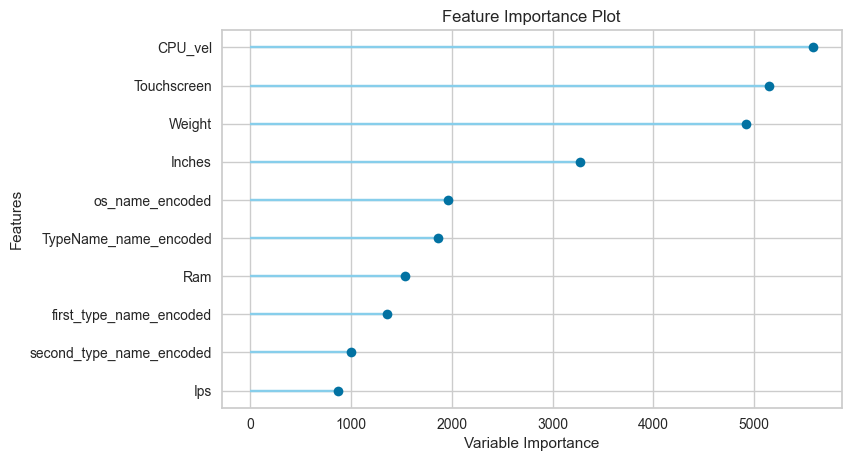

In [32]:
# Plot of Feature Importance
plot_model(lr2, plot='feature')

In [33]:
# print out the LRmodel,  線性回歸模型

print("Liner regression model:\nPrice = ")
for i in range(len(lr2.feature_names_in_)):
      print('\t',lr2.coef_[i]," ∘ ",lr2.feature_names_in_[i])

Liner regression model:
Price = 
	 -3272.32725627349  ∘  Inches
	 1541.8846745906153  ∘  Ram
	 5586.578012832403  ∘  CPU_vel
	 5141.669286981369  ∘  Touchscreen
	 877.6262468251199  ∘  Ips
	 1.6527084227884643  ∘  X_res
	 25.044948015678813  ∘  Y_res
	 -132.6424379447786  ∘  ppi
	 -2.3444837201917608  ∘  first_size
	 -2.7574712166913287  ∘  second_size
	 4917.6929469473025  ∘  Weight
	 161.69433044507977  ∘  Company_name_encoded
	 1865.381534595785  ∘  TypeName_name_encoded
	 400.0993733599325  ∘  Cpu_brand_name_encoded
	 616.9028988254275  ∘  GPU_name_encoded
	 1361.9019307516787  ∘  first_type_name_encoded
	 -1004.1550365268394  ∘  second_type_name_encoded
	 1961.0035626810443  ∘  os_name_encoded


Note
---
1. What is the most important feature is? Why? 
2. There is no significant  differce between GPU_Nvidia and GPU_Intel, surprised?
3. From the copmare_models, the best one model is `catboost`. Try to make a model by `catboost` scheme.

In [34]:

cat_model=create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3230.1772,24562924.8468,4956.0998,0.8767,0.1803,0.1514
1,3923.1966,53569257.8765,7319.1023,0.7793,0.2190,0.1700
2,4119.8641,35702305.6699,5975.1406,0.8073,0.2016,0.1584
3,3421.2264,21090549.3120,4592.4448,0.9147,0.1929,0.1566
4,3870.3436,29328613.7585,5415.5899,0.8477,0.2238,0.1814
5,3817.3777,36539457.8297,6044.7877,0.8077,0.2126,0.1648
6,4014.9227,37782304.4335,6146.7312,0.8287,0.2224,0.1742
7,3688.7873,27396594.3846,5234.1756,0.8793,0.1985,0.1610
8,3009.8045,25018345.1553,5001.8342,0.8657,0.1755,0.1384


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [35]:
pred_cat = predict_model(cat_model)
pred_cat

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,3543.8214,30126264.6031,5488.7398,0.8376,0.2002,0.1586


,Inches,Ram,CPU_vel,Touchscreen,Ips,X_res,Y_res,ppi,first_size,second_size,Weight,Company_name_encoded,TypeName_name_encoded,Cpu_brand_name_encoded,GPU_name_encoded,first_type_name_encoded,second_type_name_encoded,os_name_encoded,Price,prediction_label
912,15.6,4.0,2.0,0.0,0.0,1920.0,1080.0,141.212006,128.0,0.0,2.200,10.0,3.0,24.0,2.0,3.0,2.0,2.0,10300,10263.947305
913,15.6,6.0,2.5,0.0,0.0,1920.0,1080.0,141.212006,256.0,0.0,2.200,10.0,3.0,25.0,2.0,3.0,2.0,2.0,12000,16029.018759
914,15.6,8.0,2.5,0.0,0.0,1366.0,768.0,100.454666,256.0,0.0,2.200,5.0,3.0,25.0,2.0,3.0,2.0,2.0,16600,16451.488793
915,15.6,16.0,2.7,0.0,0.0,1920.0,1080.0,141.212006,256.0,0.0,2.300,4.0,3.0,26.0,0.0,3.0,2.0,2.0,24500,27710.320376
916,12.5,8.0,2.5,0.0,1.0,1920.0,1080.0,176.232574,256.0,0.0,1.360,10.0,4.0,25.0,2.0,3.0,2.0,2.0,29600,30263.695304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,15.6,16.0,2.8,0.0,0.0,3840.0,2160.0,282.424011,512.0,0.0,2.620,4.0,1.0,26.0,3.0,3.0,2.0,2.0,34800,44583.565066
1299,15.6,4.0,1.1,0.0,0.0,1366.0,768.0,100.454666,1000.0,0.0,2.100,0.0,3.0,27.0,2.0,1.0,2.0,2.0,7200,7074.589403
1300,15.6,4.0,2.3,0.0,0.0,1920.0,1080.0,141.212006,0.0,0.0,2.200,10.0,3.0,25.0,2.0,1.0,2.0,2.0,11100,16012.655243
1301,13.5,8.0,2.5,1.0,0.0,2256.0,1504.0,200.842560,256.0,0.0,1.252,13.0,4.0,25.0,2.0,3.0,2.0,2.0,27800,35022.844578


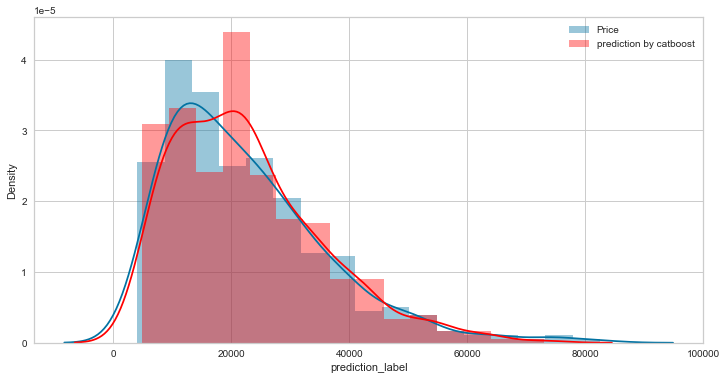

In [36]:
plt.figure(figsize=[12,6])
sns.distplot(pred_cat['Price'],label='Price')
sns.distplot(pred_cat['prediction_label'],color='red',label='prediction by catboost')
plt.legend()

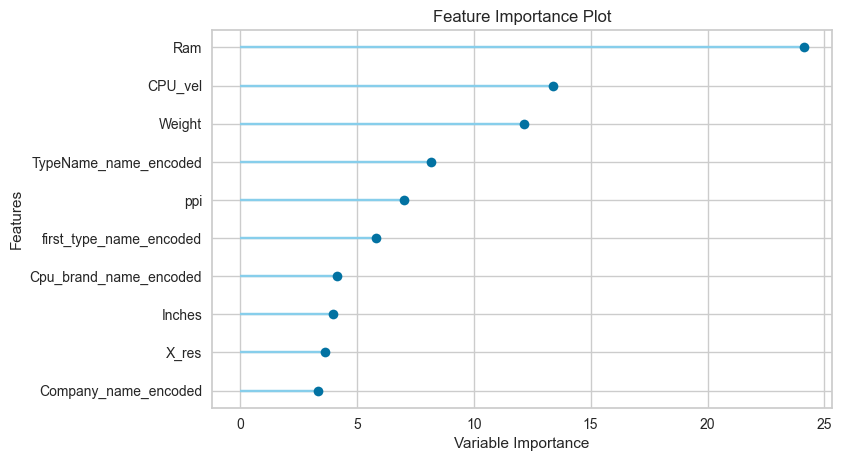

In [37]:
# Plot of Feature Importance
plot_model(cat_model, plot='feature')

<AxesSubplot: >

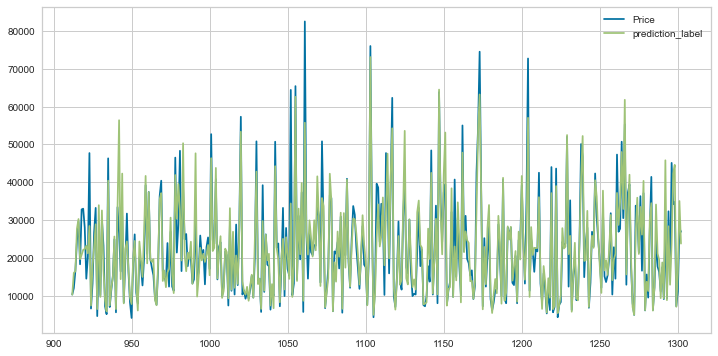

In [38]:
pred_cat[['Price','prediction_label']].plot(figsize=[12,6])

<font color="red">Note</font>
---
If no idea about what `graphviz` is, do not try to visualize the tree structure as follows, just use its prediction only! I don't know how to install graphviz in google drive too. 

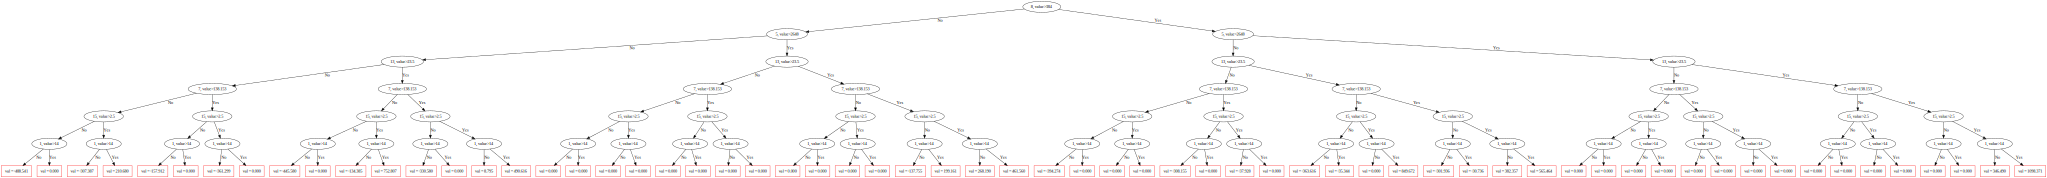

In [39]:
cat_model.plot_tree(tree_idx=0)

Self-learning
---
1. Conclude the the result of cat_model above.
2. Conclude the skills leaned in the lecture this week.

Some notes about this Project
---
1. There are nighteen features used to build model. From the vis of Important Features, it is obvious that the relation between each feature and price is different. And the another issue: Are all the features necessary? No redundant ones among them? Or is there any feature which could confuse the model decision?

Answer: There are some tools/packages in ML developed for wise selection the features in model building. One is `featurewiz`, introduced here. 

In [40]:
# !pip install featurewiz

### in Google drive
# !pip install Pillow==9.0.0
# !pip install xlrd — ignore-installed — no-deps

#import featurewiz as gwiz
from featurewiz import featurewiz


Imported 0.2.02 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']



In [36]:
wiz =gwiz.FeatureWiz(verbose=1)

wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        


In [41]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.30, random_state=42)

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
Correlation Limit = 0.7
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Regression problem ####
    Loaded train data. Shape = (1303, 19)
#### Single_Label Regression problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
        No variables were removed since no ID o

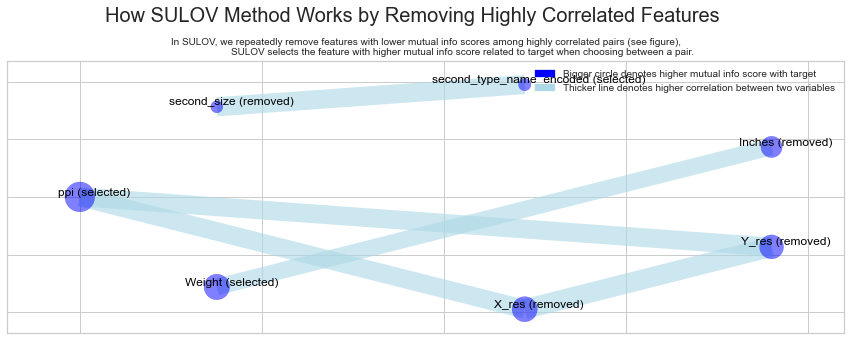

Time taken for SULOV method = 0 seconds
    Adding 0 categorical variables to reduced numeric variables  of 14
Final list of selected 14 vars after SULOV = ['CPU_vel', 'Company_name_encoded', 'Cpu_brand_name_encoded', 'GPU_name_encoded', 'Ips', 'Ram', 'Touchscreen', 'TypeName_name_encoded', 'first_size', 'first_type_name_encoded', 'os_name_encoded', 'ppi', 'Weight', 'second_type_name_encoded']
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 14 
    Taking top 4 features per iteration...
    XGBoost version using 1.6.2 as tree method: hist
Number of booster rounds = 100
        using 14 variables...
            selecting 7 features

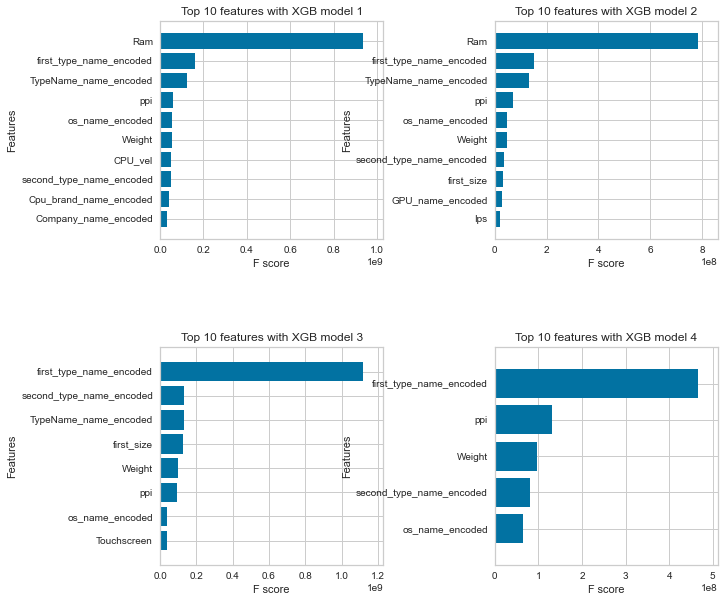

    Completed XGBoost feature selection in 0 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 9 important features:
['Ram', 'first_type_name_encoded', 'TypeName_name_encoded', 'ppi', 'os_name_encoded', 'Weight', 'CPU_vel', 'second_type_name_encoded', 'first_size']
Total Time taken for featurewiz selection = 1 seconds
Output contains a list of 9 important features and a train dataframe


In [42]:
data=df[num_features+cat_features+target]

features = featurewiz(data, target, corr_limit=0.70,verbose=2)

In [46]:
target

['Price']

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
Correlation Limit = 0.9
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Regression problem ####
    Loaded train data. Shape = (912, 19)
#### Single_Label Regression problem ####
loading the entire test dataframe - there is no nrows limit applicable #########
    Loaded test data. Shape = (391, 19)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
##############################################

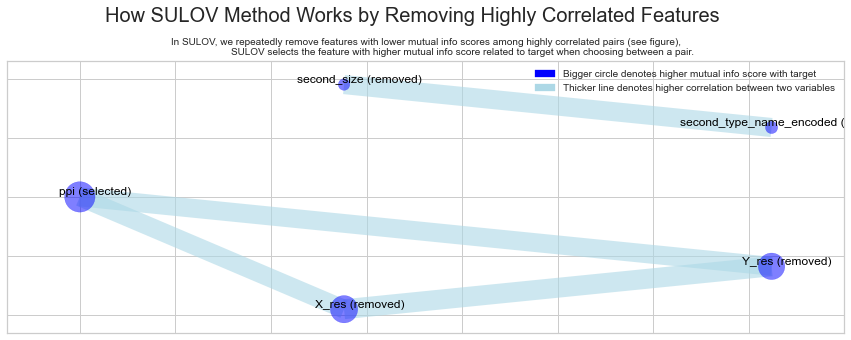

Time taken for SULOV method = 0 seconds
    Adding 0 categorical variables to reduced numeric variables  of 15
Final list of selected 15 vars after SULOV = ['CPU_vel', 'Company_name_encoded', 'Cpu_brand_name_encoded', 'GPU_name_encoded', 'Inches', 'Ips', 'Ram', 'Touchscreen', 'TypeName_name_encoded', 'Weight', 'first_size', 'first_type_name_encoded', 'os_name_encoded', 'ppi', 'second_type_name_encoded']
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 15 
    Taking top 4 features per iteration...
    XGBoost version using 1.6.2 as tree method: hist
Number of booster rounds = 100
        using 15 variables...
            selecting 

In [43]:
trainm, testm = featurewiz(train, target,  test_data=test, verbose=1)# corr_limit=0.90, 


In [44]:
feats = testm.columns.tolist()
print(feats)

['Ram', 'first_type_name_encoded', 'TypeName_name_encoded', 'ppi', 'Inches', 'CPU_vel', 'Weight', 'Touchscreen', 'first_size']


Note
---
Though there are 19 features considered in model building in pycaret test, featurewiz suggests that there might be only a little difference between  using 9 features and all 19's.

LazyPredict
---
Another similar project, build more than 40 models only in few lines! 

In [53]:
import xgboost as xgb
xgb.__version__

'1.6.2'

In [ ]:
!pip install lazypredict

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
X=df[num_features+cat_features]
y=df[target].apply(lambda x: np.log1p(x))

X, y = shuffle(X,y, random_state=42)

#offset = int(X.shape[0] * 0.7)

#X_train, y_train = X[:offset], y[:offset]
#X_test, y_test = X[offset:], y[offset:]

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y.values[:,0],test_size=0.3)


In [ ]:
import lazypredict

from lazypredict.Supervised import LazyRegressor


In [ ]:
#reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None,predictions=True)
reg = LazyRegressor(verbose=0, ignore_warnings=True, predictions=True)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

In [ ]:
models

In [ ]:
predictions

In [ ]:
pred_df=pd.DataFrame()

In [ ]:
pred_df['Xgboost']=predictions['XGBRegressor'].apply(lambda x:np.expm1(x))
pred_df['Price']=np.expm1(y_test)

In [ ]:
plt.figure(figsize=[12,6])
sns.distplot(pred_df['Price'],label='Price')
sns.distplot(pred_df['Xgboost'],color='red',label='prediction by Xgboost')
plt.legend()

Note
---
1. only for test
2. no model deployment
3. no exact trained model information, parameters etc.

Feature Selection
---

In [69]:
X=df[num_features+cat_features]
y=df[target].apply(lambda x: np.log1p(x))

X, y = shuffle(X,y, random_state=42)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42,test_size=0.3) 

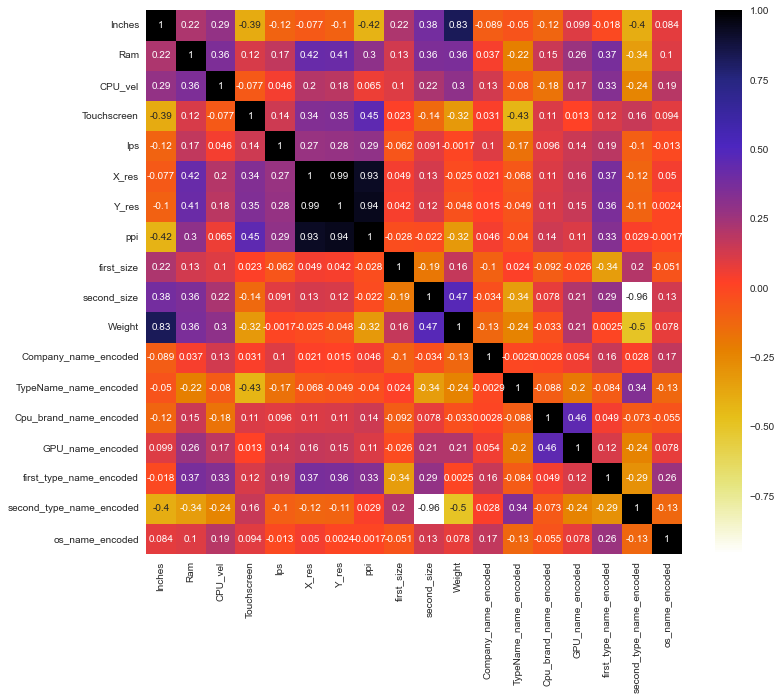

In [73]:
# Pearson Correlation
cor = X_train.corr()
plt.figure(figsize=(12,10))
sns.heatmap(cor, cmap=plt.cm.CMRmap_r,annot=True);

In [74]:
def correlation(dataset, threshold):
    col_corr = set()  
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: colname = corr_matrix.columns[i]                  
    col_corr.add(colname)
    return col_corr 

In [80]:
corr_features = correlation(X_train, 0.85)
corr_features

{'second_type_name_encoded'}

In [81]:
# Removing correlated features
X_train.drop(corr_features,axis=1)
X_test.drop(corr_features,axis=1)
#X_train     

,Inches,Ram,CPU_vel,Touchscreen,Ips,X_res,Y_res,ppi,first_size,second_size,Weight,Company_name_encoded,TypeName_name_encoded,Cpu_brand_name_encoded,GPU_name_encoded,first_type_name_encoded,os_name_encoded
2,15.6,8,2.5,0,0,1920,1080,141.211998,256,0,1.86,7,3,25,2,3,1
942,15.6,4,2.5,0,0,1366,768,100.454670,0,0,2.23,0,3,25,2,1,2
1122,14.0,8,2.3,0,0,1920,1080,157.350512,256,0,1.43,7,3,25,2,3,2
831,14.0,16,2.6,0,1,2560,1440,209.800683,512,0,1.10,10,4,26,2,3,2
875,12.5,8,2.8,0,0,1920,1080,176.232574,256,0,1.60,4,4,26,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,11.6,4,1.6,0,0,1366,768,135.094211,32,0,1.40,0,2,27,2,0,2
25,15.6,4,2.0,0,0,1366,768,100.454670,1000,0,2.30,4,3,24,2,1,2
1131,14.0,8,2.6,1,1,1920,1080,157.350512,512,0,1.80,10,0,26,3,3,2
930,15.6,4,1.1,0,0,1366,768,100.454670,1000,0,2.20,10,3,27,2,1,2
